# EDA

For this analyis, we will use this dataset whiwh is already annoted. We will use a simplified version

https://huggingface.co/datasets/christophsonntag/OLID

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

import tensorflow_hub as hub


In [ ]:
splits = {'train': 'train.csv', 'test': 'test.csv'}
df = pd.read_csv("hf://datasets/christophsonntag/OLID/" + splits["train"])

In [ ]:
df.shape

(13240, 6)

In [ ]:
df.head()

,id,tweet,cleaned_tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,ask native americans take,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home drunk maga trump 2020,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,amazon investigating chinese employees selling...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone vetaken piece shit volcano,OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama wanted liberals illegals move red states,NOT,NaN,NaN


In [ ]:
df.isna().sum()/df.shape[0]*100

,0
id,0.000000
tweet,0.000000
cleaned_tweet,0.528701
subtask_a,0.000000
subtask_b,66.767372
subtask_c,70.725076


As there are lots of missing data for b and c, let's keep only subtask_a and clean it
Let's keep only the original tweet so that we have the hand on the preprocessing

In [ ]:
selected_columns = ['tweet', 'subtask_a']
df_simplified = df[selected_columns]
df_simplified.head()

,tweet,subtask_a
0,@USER She should ask a few native Americans wh...,OFF
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF
2,Amazon is investigating Chinese employees who ...,NOT
3,"@USER Someone should'veTaken"" this piece of sh...",OFF
4,@USER @USER Obama wanted liberals &amp; illega...,NOT


In [ ]:
df_simplified['target'] = 0

df_simplified.loc[df_simplified['subtask_a'] == 'OFF', 'target'] = 1
df_simplified = df_simplified.drop(columns=['subtask_a'])
df_simplified.head()


<ipython-input-42-15e8101ec70a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_simplified['target'] = 0


,tweet,target
0,@USER She should ask a few native Americans wh...,1
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,1
2,Amazon is investigating Chinese employees who ...,0
3,"@USER Someone should'veTaken"" this piece of sh...",1
4,@USER @USER Obama wanted liberals &amp; illega...,0


In [ ]:
df_simplified.target.value_counts()

,count
target,
0,8840
1,4400


In [ ]:
df_simplified.head()

,tweet,target
0,@USER She should ask a few native Americans wh...,1
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,1
2,Amazon is investigating Chinese employees who ...,0
3,"@USER Someone should'veTaken"" this piece of sh...",1
4,@USER @USER Obama wanted liberals &amp; illega...,0


# Preprocessing

In [ ]:
!python -m spacy download en_core_web_sm -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 79.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.19.1 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.13.1 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import en_core_web_sm
nlp = en_core_web_sm.load()
nlp.Defaults.stop_words.add("user") #added after the top 20 words analysis
nlp.Defaults.stop_words.add("url")
from spacy.lang.en.stop_words import STOP_WORDS


In [ ]:
df_simplified["text_clean"] = df_simplified["tweet"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
df_simplified["text_clean"] = df_simplified["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
df_simplified["text_clean"] = df_simplified["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

df_simplified.head()

,tweet,target,text_clean
0,@USER She should ask a few native Americans wh...,1,ask native americans
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,1,home drunk maga trump2020
2,Amazon is investigating Chinese employees who ...,0,amazon investigate chinese employee sell inter...
3,"@USER Someone should'veTaken"" this piece of sh...",1,shouldvetaken piece shit volcano
4,@USER @USER Obama wanted liberals &amp; illega...,0,obama want liberals amp illegal red state


Let's check if there are some words to remove that will be added to the stop words

In [ ]:
from collections import Counter

all_text = ' '.join(df_simplified['text_clean'].tolist())

words = all_text.split()
word_counts = Counter(words)
top_100_words = word_counts.most_common(20)
top_100_words

[('liberal', 1601),
 ('gun', 1527),
 ('control', 1234),
 ('antifa', 1154),
 ('like', 1148),
 ('s', 1038),
 ('conservative', 1035),
 ('maga', 1005),
 ('people', 926),
 ('know', 828),
 ('think', 772),
 ('amp', 636),
 ('trump', 625),
 ('good', 612),
 ('want', 558),
 ('right', 556),
 ('need', 537),
 ('m', 530),
 ('time', 448),
 ('look', 446)]

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer() # instanciate the tokenizer
tokenizer.fit_on_texts(df_simplified["text_clean"])
df_simplified["text_encoded"] = tokenizer.texts_to_sequences(df_simplified.text_clean)
df_simplified["len_review"] = df_simplified["text_encoded"].apply(lambda x: len(x))
df_simplified = df_simplified[df_simplified["len_review"]!=0]
df_simplified.head()

,tweet,target,text_clean,text_encoded,len_review
0,@USER She should ask a few native Americans wh...,1,ask native americans,"[82, 1726, 159]",3
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,1,home drunk maga trump2020,"[151, 734, 8, 680]",4
2,Amazon is investigating Chinese employees who ...,0,amazon investigate chinese employee sell inter...,"[2854, 506, 1424, 1353, 400, 3933, 1152, 7083,...",18
3,"@USER Someone should'veTaken"" this piece of sh...",1,shouldvetaken piece shit volcano,"[7084, 401, 24, 7085]",4
4,@USER @USER Obama wanted liberals &amp; illega...,0,obama want liberals amp illegal red state,"[122, 15, 1153, 12, 246, 358, 85]",7


In [ ]:
len(tokenizer.word_index)

16936

In [ ]:
text_pad = tf.keras.preprocessing.sequence.pad_sequences(df_simplified.text_encoded, padding="post",maxlen=100)
full_ds = tf.data.Dataset.from_tensor_slices((text_pad, df_simplified.target))



In [ ]:
# Train Test Split
from sklearn.model_selection import train_test_split

xtrain, xval, ytrain, yval = train_test_split(text_pad,df_simplified.target, test_size=0.2)


In [ ]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

In [ ]:
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

# Classification Model

##LSTM

Let's try with a LSTM model

In [ ]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM, GlobalMaxPooling1D, Dropout

vocab_size = len(tokenizer.word_index)
model_lstm = tf.keras.Sequential([
                  Embedding(vocab_size+1, 64, input_shape=[100,],name="embedding"),
                  LSTM(units=64, return_sequences=True),
                  LSTM(units=64, return_sequences=True),
                  GlobalMaxPooling1D(),
                  Dropout(0.2),
                  Dense(1, activation="sigmoid")
])

# Compile the model
model_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Loss for binary classification
    metrics=['accuracy']
)

# Summary of the model
model_lstm.summary()





Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           1083968   
                                                                 
 lstm_2 (LSTM)               (None, 100, 64)           33024     
                                                                 
 lstm_3 (LSTM)               (None, 100, 64)           33024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                      

In [ ]:
history_lstm = model_lstm.fit(train_batch, epochs = 3, validation_data=val_batch)

Epoch 1/3
165/165 [==============================] - 41s 217ms/step - loss: 0.6310 - accuracy: 0.6650 - val_loss: 0.5757 - val_accuracy: 0.6724
Epoch 2/3
165/165 [==============================] - 33s 203ms/step - loss: 0.4596 - accuracy: 0.7961 - val_loss: 0.5420 - val_accuracy: 0.7371
Epoch 3/3
165/165 [==============================] - 34s 206ms/step - loss: 0.2941 - accuracy: 0.8873 - val_loss: 0.6439 - val_accuracy: 0.7511


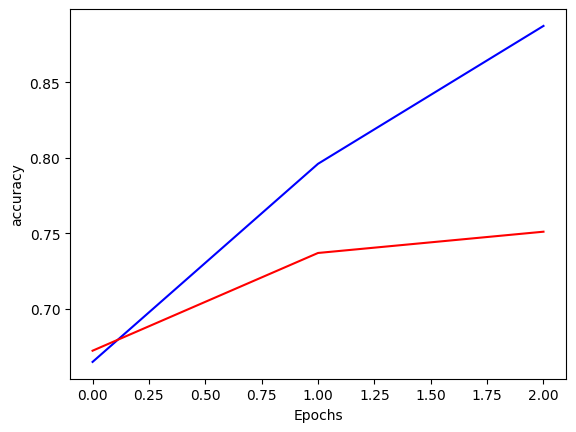

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history_lstm.history["accuracy"], color="b")
plt.plot(history_lstm.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

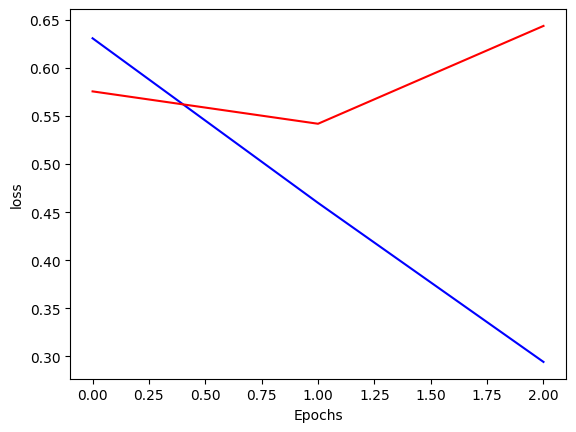

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history_lstm.history["loss"], color="b")
plt.plot(history_lstm.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [ ]:
y_pred_probs = model_lstm.predict(xval)  # X_test is the test dataset
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary class (threshold 0.5)

83/83 [==============================] - 4s 33ms/step


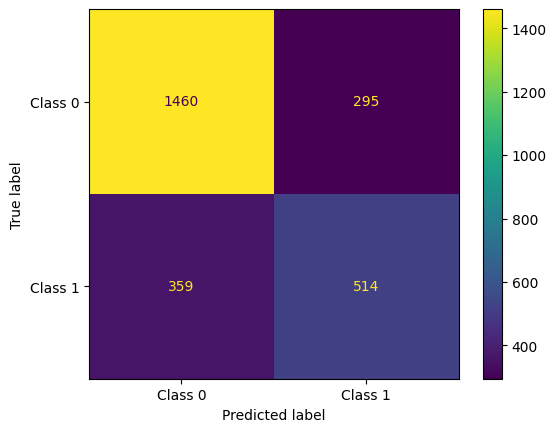

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(yval, y_pred)  # y_test is the true labels for X_test

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

accuracy = accuracy_score(yval, y_pred)
precision = precision_score(yval, y_pred)
recall = recall_score(yval, y_pred)
f1 = f1_score(yval, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

metrics_lstm = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

Accuracy: 0.7511415525114156
Precision: 0.6353522867737948
Recall: 0.588774341351661
F1-Score: 0.6111771700356718


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Input texts
input_texts = [
    'you motherfucking cunt',
    'I love new Taylor Swift album',
    'Such a beautiful weather today',
    'All gay should burn in hell',
    'fuck you faggot'
]

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(input_texts)

# Pad sequences to ensure they have the same length
MAX_SEQUENCE_LENGTH = 50  # Replace with the value used during model training
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Predict probabilities
test_pred_prod = model_lstm.predict(padded_sequences)

# Convert probabilities to binary predictions
test_pred = (test_pred_prod > 0.5).astype(int).flatten()

# Map predictions to labels
test_pred_final = ["hate" if pred == 1 else "not hate" for pred in test_pred]

print(test_pred_final)
print(test_pred_prod)


1/1 [==============================] - 0s 43ms/step
['hate', 'not hate', 'not hate', 'hate', 'hate']
[[0.8520675 ]
 [0.05178134]
 [0.01044636]
 [0.8771516 ]
 [0.94932497]]


Seems like we are not getting above 74% acccuracy on the test sest with a recal only around 60%, meaning 40%  of the hatefull messages are not flagged


# GRU

In [ ]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM, GlobalMaxPooling1D, Dropout

vocab_size = len(tokenizer.word_index)
model_gru = tf.keras.Sequential([
                  Embedding(vocab_size+1, 32, input_shape=[100,],name="embedding"),
                  GRU(units=64, return_sequences=True), # returns the last output
                  GlobalMaxPooling1D(),
                  Dropout(0.2),
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),
                  Dense(4, activation='relu'),
                  Dense(1, activation="sigmoid")
])



# Compile the model
model_gru.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Loss for binary classification
    metrics=['accuracy']
)

# Summary of the model
model_gru.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           541984    
                                                                 
 gru_2 (GRU)                 (None, 100, 64)           18816     
                                                                 
 global_max_pooling1d_4 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 16)                1040      
                                                                 
 dense_11 (Dense)            (None, 8)                 136       
                                                      

In [ ]:
history_gru = model_gru.fit(train_batch, epochs = 4, validation_data=val_batch)

Epoch 1/4
165/165 [==============================] - 21s 97ms/step - loss: 0.6341 - accuracy: 0.6646 - val_loss: 0.5643 - val_accuracy: 0.7253
Epoch 2/4
165/165 [==============================] - 16s 96ms/step - loss: 0.4686 - accuracy: 0.7839 - val_loss: 0.5184 - val_accuracy: 0.7355
Epoch 3/4
165/165 [==============================] - 16s 95ms/step - loss: 0.3228 - accuracy: 0.8690 - val_loss: 0.5593 - val_accuracy: 0.7610
Epoch 4/4
165/165 [==============================] - 16s 94ms/step - loss: 0.2340 - accuracy: 0.9106 - val_loss: 0.6706 - val_accuracy: 0.7409


83/83 [==============================] - 2s 23ms/step


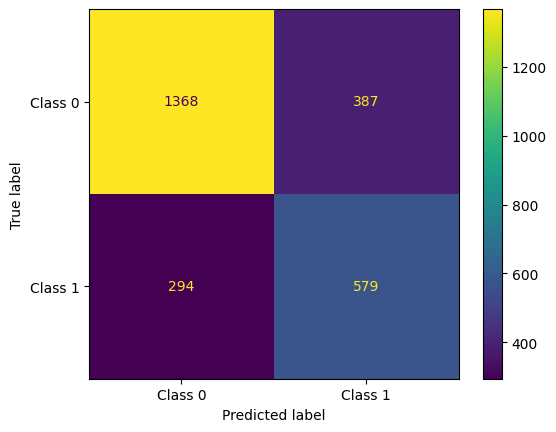

In [ ]:
y_pred_probs = model_gru.predict(xval)  # X_test is the test dataset
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary class (threshold 0.5)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(yval, y_pred)  # y_test is the true labels for X_test

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

accuracy = accuracy_score(yval, y_pred)
precision = precision_score(yval, y_pred)
recall = recall_score(yval, y_pred)
f1 = f1_score(yval, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

metrics_gru = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

Accuracy: 0.7408675799086758
Precision: 0.5993788819875776
Recall: 0.6632302405498282
F1-Score: 0.6296900489396411


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Input texts
input_texts = [
    'you motherfucking cunt',
    'I love new Taylor Swift album',
    'Such a beautiful weather today',
    'All gay should burn in hell',
    'fuck you faggot'
]

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(input_texts)

# Pad sequences to ensure they have the same length
MAX_SEQUENCE_LENGTH = 50  # Replace with the value used during model training
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Predict probabilities
test_pred_prod = model_gru.predict(padded_sequences)

# Convert probabilities to binary predictions
test_pred = (test_pred_prod > 0.5).astype(int).flatten()

# Map predictions to labels
test_pred_final = ["hate" if pred == 1 else "not hate" for pred in test_pred]

print(test_pred_final)
np.round(test_pred_prod, 2)


1/1 [==============================] - 0s 83ms/step
['hate', 'not hate', 'not hate', 'hate', 'hate']


array([[0.86],
       [0.04],
       [0.  ],
       [0.9 ],
       [0.95]], dtype=float32)


##BERT

Let's check with BERT

In [ ]:
!pip install -U "tensorflow-text==2.13.*"

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.17.0
    Uninstalling tf_keras

In [ ]:
!pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 9.4 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=feab3063f4d4342c9a523aada078e846522ef891beac2a9222e6622629b1f2af
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
X = np.array(df_simplified.text_clean)
y = np.array(df_simplified.target)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post', truncating='post')


X_train_pad

array([[2109,   48, 6167, ...,    0,    0,    0],
       [  23,    0,    0, ...,    0,    0,    0],
       [6168, 2401, 6169, ...,    0,    0,    0],
       ...,
       [ 155,   16, 4317, ...,    0,    0,    0],
       [ 557,   54, 2176, ...,    0,    0,    0],
       [ 232,   87,  243, ...,    0,    0,    0]], dtype=int32)

In [ ]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=100, padding='post', truncating='post')

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder= 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'

bert_preprocess = hub.KerasLayer(tfhub_handle_preprocess)
bert_encoder = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = bert_preprocess(text_input)
outputs = bert_encoder(preprocessing_layer)

l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])

l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

classifier_model = tf.keras.Model(inputs=[text_input], outputs = [l])

classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [ ]:
classifier_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
classifier_history = classifier_model.fit(X_train, y_train, epochs = 10, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
329/329 [==============================] - 1166s 4s/step - loss: 0.6099 - accuracy: 0.6763 - val_loss: 0.5781 - val_accuracy: 0.6941
Epoch 2/10
329/329 [==============================] - 1163s 4s/step - loss: 0.5634 - accuracy: 0.7148 - val_loss: 0.5428 - val_accuracy: 0.7283
Epoch 3/10
329/329 [==============================] - 1159s 4s/step - loss: 0.5478 - accuracy: 0.7271 - val_loss: 0.5347 - val_accuracy: 0.7397
Epoch 4/10
329/329 [==============================] - 1154s 4s/step - loss: 0.5423 - accuracy: 0.7324 - val_loss: 0.5305 - val_accuracy: 0.7420
Epoch 5/10
329/329 [==============================] - 1159s 4s/step - loss: 0.5366 - accuracy: 0.7307 - val_loss: 0.5296 - val_accuracy: 0.7359
Epoch 6/10
329/329 [==============================] - 1133s 3s/step - loss: 0.5349 - accuracy: 0.7332 - val_loss: 0.5343 - val_accuracy: 0.7336
Epoch 7/10
329/329 [==============================] - 1161s 4s/step - loss: 0.5316 - accuracy: 0.7329 - val_loss: 0.5230 - val_accuracy:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
classifier_model.save("/content/drive/MyDrive/Jedha/hate_speech_bert_model")


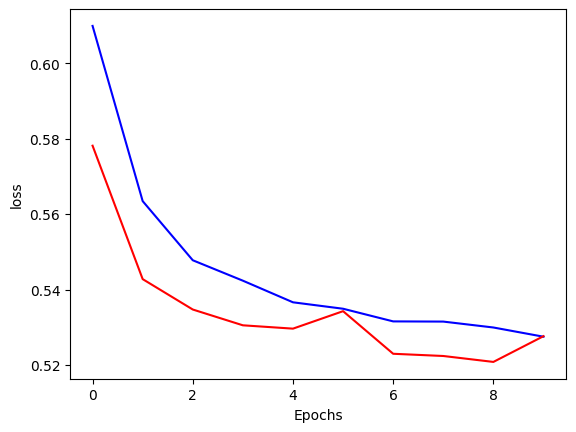

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(classifier_history.history["loss"], color="b")
plt.plot(classifier_history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

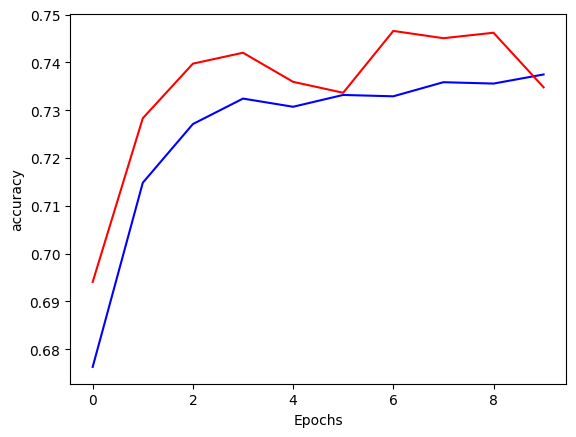

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(classifier_history.history["accuracy"], color="b")
plt.plot(classifier_history.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

In [ ]:
y_pred_probs = classifier_model.predict(X_test)  # X_test is the test dataset
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary class (threshold 0.5)

83/83 [==============================] - 234s 3s/step


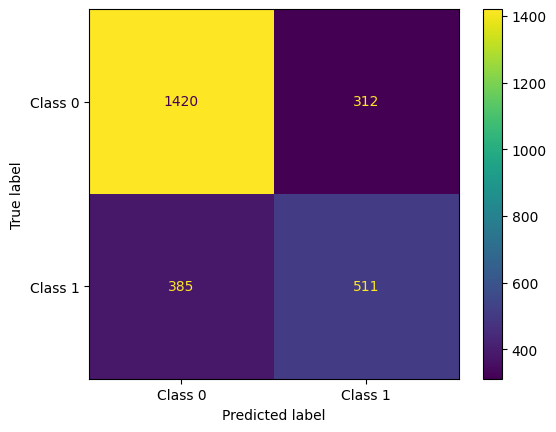

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)  # y_test is the true labels for X_test

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

metrics_bert = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

Accuracy: 0.734779299847793
Precision: 0.6208991494532199
Recall: 0.5703125
F1-Score: 0.5945317044793484


In [ ]:
test_pred_prod = classifier_model.predict(['you motherfucking cunt', 'I love new Taylor Swift album',"Such a beatiful weather today", "All gay should burn in hell","fuck you faggot"])
test_pred = (test_pred_prod > 0.5).astype(int)
test_pred_final = ["hate" if pred == 1 else "not hate" for pred in test_pred]
test_pred_final

1/1 [==============================] - 1s 695ms/step


['hate', 'not hate', 'not hate', 'hate', 'hate']

# Conclusion

Overall, it seems that BERT has not improved performance despite very long training time.

GRU seems to have the best performance

In [ ]:
data = [metrics_lstm, metrics_bert,metrics_gru]
names = ["LSTM Model", "BERT Model","GRU model"]

pd.DataFrame(data, index=names).sort_values(by='f1', ascending=False)

,accuracy,precision,recall,f1
GRU model,0.740868,0.599379,0.663230,0.629690
LSTM Model,0.751142,0.635352,0.588774,0.611177
BERT Model,0.734779,0.620899,0.570312,0.594532
